In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import calendar
import time
from matplotlib import colors
from sklearn import preprocessing
import cartopy.crs as crs
import cartopy.feature as cfeature
import scipy

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def read_data(init):
    """
    Reads and concatenates parquet files for NAM, GFS, and HRRR models for the years 2018 to 2021.
    Filters out forecasts with lead times of 0.

    Parameters:
        init (int): Initialization time in UTC.

    Returns:
        tuple: A tuple containing three pandas dataframes for NAM, GFS, and HRRR models respectively.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [3]:
def format_df(df):
    """
    This function takes a Pandas DataFrame `df` and returns a new DataFrame `error_months` that contains the mean temperature error (`t2m_error`) for each station, grouped by month.

    Parameters:
    - `df` (Pandas DataFrame): the input DataFrame to be processed

    Returns:
    - `error_months` (Pandas DataFrame): a new DataFrame that contains the mean temperature error for each station, grouped by month. The resulting DataFrame has three columns:
        - `time.dt.month`: the month of the year
        - `station`: the station identifier
        - `t2m_error`: the mean temperature error for the given month and station.
    """
    df = df[df["lead_time_DAY"] == 0]
    df = df[df["lead_time_HOUR"] <= 18]
    error_months = (
        (df.groupby([df.time.dt.month, "station"])[f"t2m_error"].mean())
        .to_frame()
        .reset_index()
    )
    return error_months

In [4]:
def get_corrs(df, lulc, keys):
    """
    Computes correlation coefficients between land use/land cover and temperature error for each month of the year.

    Args:
    - df (pd.DataFrame): A dataframe containing the t2m_error column and a time column with values 1-12 indicating the month.
    - lulc (pd.DataFrame): A dataframe containing the land use/land cover data with column names matching the keys parameter.
    - keys (list): A list of strings indicating the column names in lulc to compute correlations with.

    Returns:
    - Tuple of pd.DataFrame: Four dataframes with columns for each month (1-12) and rows for each land use/land cover column in keys:
        - df_pers: Pearson correlation coefficients.
        - df_rho: Spearman correlation coefficients.
        - df_tau: Kendall correlation coefficients.
        - df_p_score: P-values for Pearson correlation coefficients.
    """
    df_pers = pd.DataFrame()
    df_rho = pd.DataFrame()
    df_tau = pd.DataFrame()
    df_p_score = pd.DataFrame()
    for i in np.arange(1, 13):
        pers_ls = []
        rho_ls = []
        tau_ls = []
        p_score_ls = []
        df = months_df[months_df["time"] == i]
        for col, val in lulc.iteritems():
            # get correlations
            pers = scipy.stats.pearsonr(lulc[col], df["t2m_error"])[0]
            p_score = scipy.stats.pearsonr(lulc[col], df["t2m_error"])[1]
            rho = scipy.stats.spearmanr(lulc[col], df["t2m_error"])[0]
            tau = scipy.stats.kendalltau(lulc[col], df["t2m_error"])[0]

            # append
            pers_ls.append(pers)
            rho_ls.append(rho)
            tau_ls.append(tau)
            p_score_ls.append(p_score)

        df_pers1 = pd.DataFrame(index=keys)
        df_pers1[f"{i}"] = pers_ls
        df_rho1 = pd.DataFrame(index=keys)
        df_rho1[f"{i}"] = rho_ls
        df_tau1 = pd.DataFrame(index=keys)
        df_tau1[f"{i}"] = tau_ls
        df_p_score1 = pd.DataFrame(index=keys)
        df_p_score1[f"{i}"] = p_score_ls

        df_pers = pd.concat([df_pers, df_pers1], axis=1)
        df_rho = pd.concat([df_rho, df_rho1], axis=1)
        df_tau = pd.concat([df_tau, df_tau1], axis=1)
        df_p_score = pd.concat([df_p_score, df_p_score1], axis=1)

    return df_pers, df_rho, df_tau, df_p_score

In [5]:
def plot_heatmap(df, corr_type):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_title(f"{corr_type} Correlation Coefficients by Landtype")
    ax = sns.heatmap(df.T, vmin=-1, vmax=1, cmap=cm.seismic, annot=True)
    ax.set_ylabel("Month")
    ax.set_xlabel("Aspect/Slope")
    plt.tight_layout()

In [6]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [7]:
lulc = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/aspect_gfs.csv")
lulc = lulc.drop(columns=["site", "station"])
keys = lulc.keys()

In [8]:
months_df = format_df(gfs_fcast_and_error_df)

In [9]:
months_df

,time,station,t2m_error
0,1,ADDI,-0.265366
1,1,ANDE,-0.502951
2,1,BATA,-0.302963
3,1,BEAC,-0.476425
4,1,BELD,-0.199078
...,...,...,...
1507,12,WFMB,0.367677
1508,12,WGAT,0.472789
1509,12,WHIT,-0.305064
1510,12,WOLC,-0.517415


# GFS

In [10]:
df_pers, df_rho, df_tau, df_p_score = get_corrs(months_df, lulc, keys)

/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767677/20

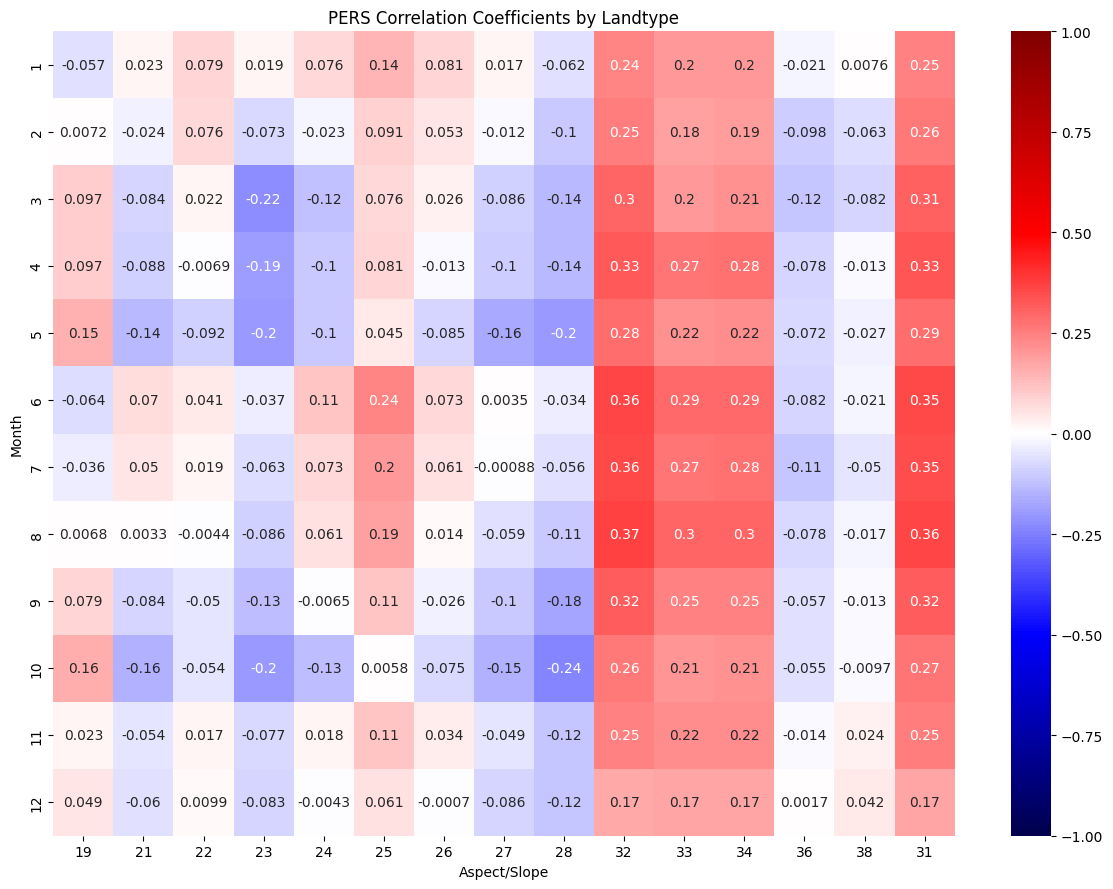

In [11]:
plot_heatmap(df_pers, "PERS")

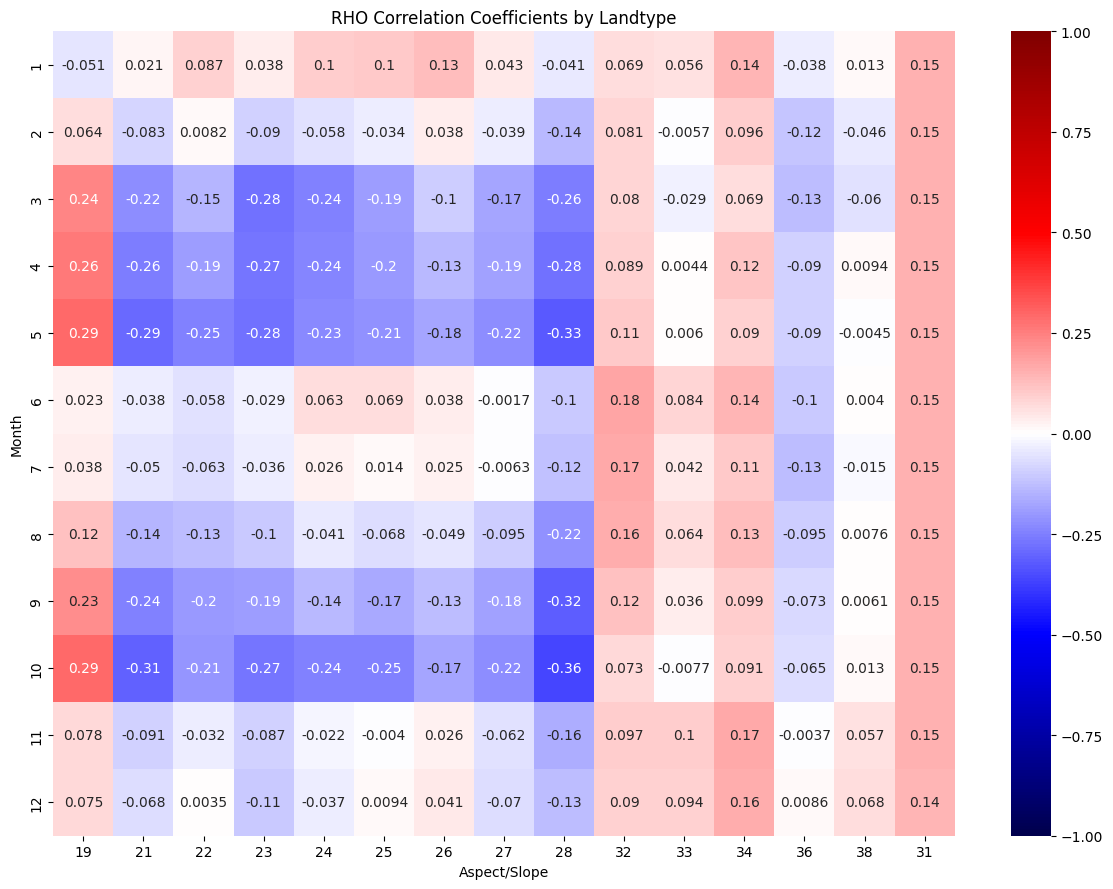

In [12]:
plot_heatmap(df_rho, "RHO")

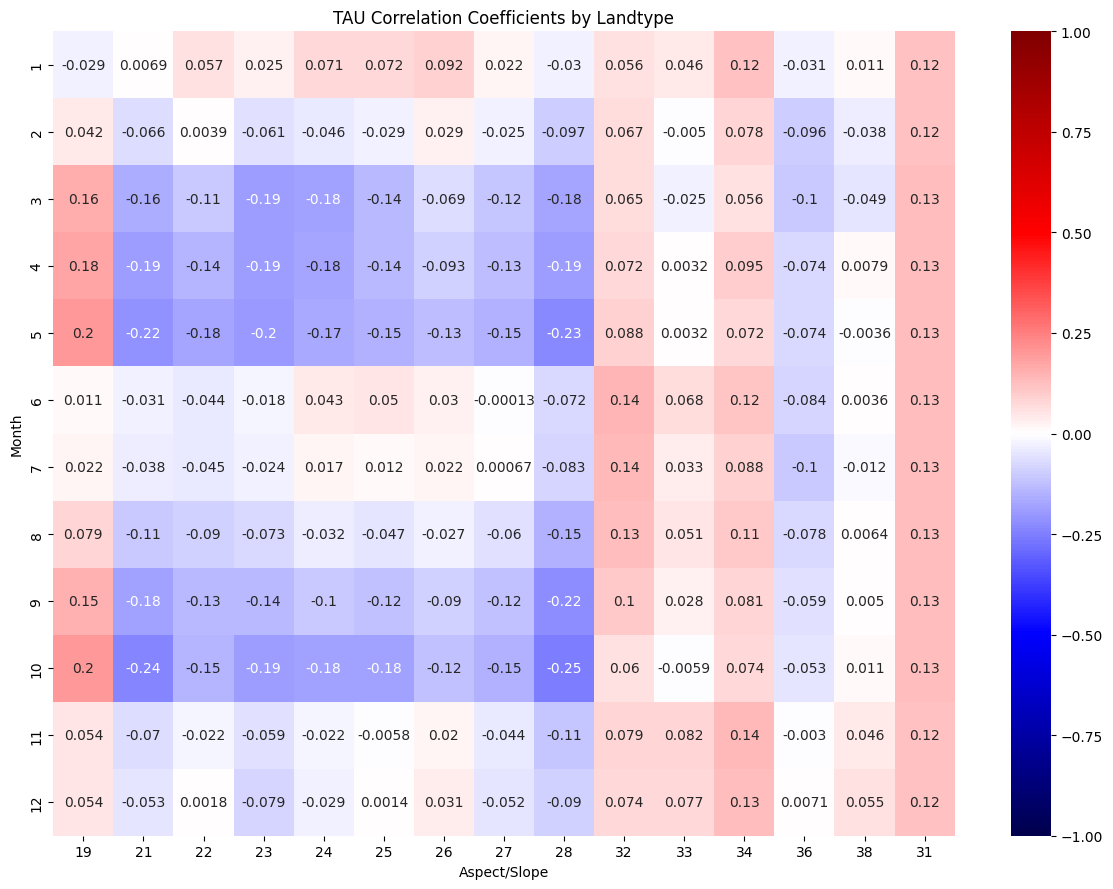

In [13]:
plot_heatmap(df_tau, "TAU")

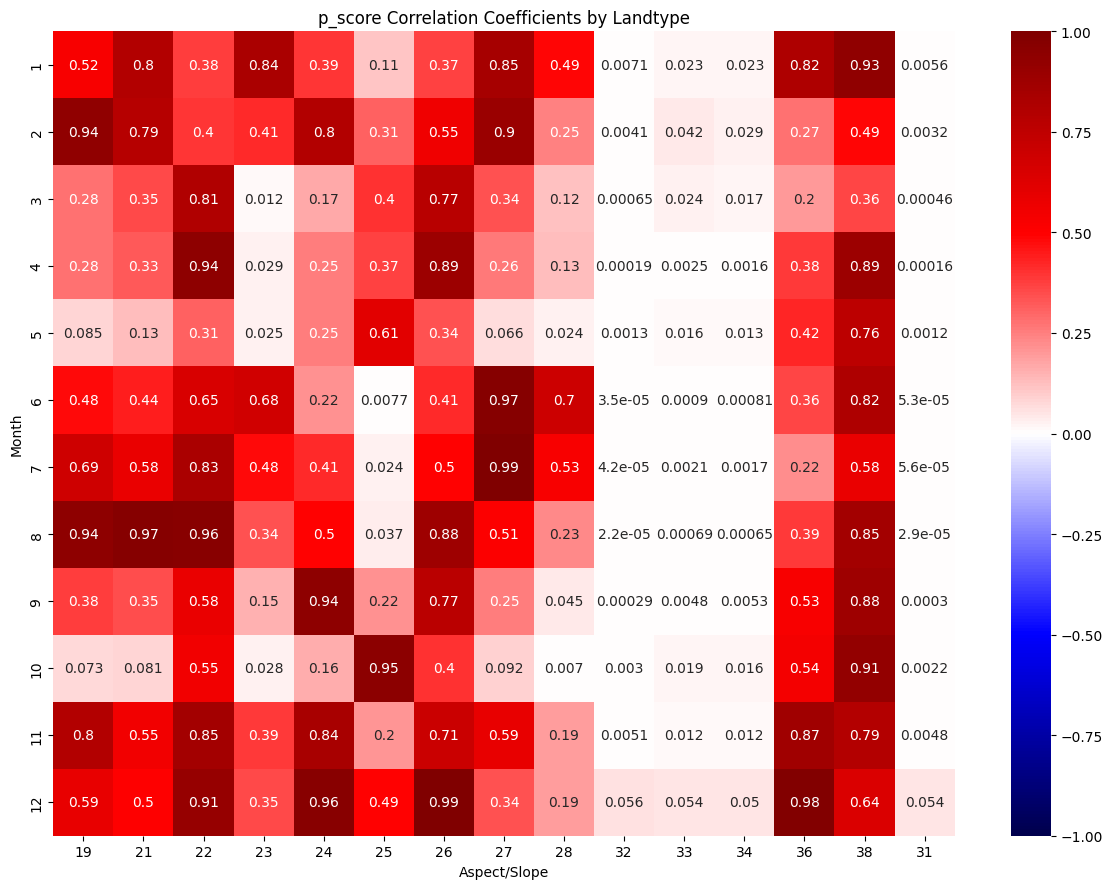

In [14]:
plot_heatmap(df_p_score, "p_score")